# Building Intuition of Convex Optimisation in Trading with CVXR

This article continues our recent stat arb series. The previous articles are linked below:
- [A short take on stat arb trading in the real world](https://robotwealth.com/a-short-take-on-real-world-pairs-trading/)
- [A general approach for exploiting stat arb alphas](https://robotwealth.com/a-general-approach-for-exploiting-statistical-arbitrage-alphas/)
- [Ideas for crypto stat arb features](https://robotwealth.com/ideas-for-crypto-stat-arb-features/)
- [Quantifying and combining crypto alphas](https://robotwealth.com/quantifying-and-combining-crypto-alphas/)
- [A simple and effective way to manage turnover and not get killed by costs](https://robotwealth.com/a-simple-effective-way-to-manage-turnover-and-not-get-killed-by-costs/)
- [How to model features as expected returns](https://robotwealth.com/how-to-model-features-as-expected-returns/)

Next, we'll build some intuition for using convex optimisation to manage real-world trade-offs in execution. 

Imagine you've quantified some signals that are predictive of next-day returns. You've done the grunt work of the research phase:
- Understood their strength and decay characteristics
- Gotten a handle on the rate at which they change and hence their impact on turnover
- Examined how they changed over time
- Modelled them as expected returns

The next phase is implementation. This answers the question: "Given these signals and my real-world constraints and objectives, what trading decisions am I going to make?"

This sounds straightforward, but it's nuanced. 

Often, if you naively trade the positions implied by your signals (for example without considering costs), you end up trading more frequently than you need to and getting killed with costs. 

Implementation is all about navigating trade-offs. For example, you have a signal that is noisily correlated with future returns. But you also incur a cost every time you trade. 

Maybe you care about ending up with positions concentrated in similar assets as well as maximising your expected returns.  

Maybe you have a limit on how net long or short you want to be, or how much leverage you want to take. 

Clearly, your signals are only one input into your trading decisions. 

In the article *[A Simple, Effective Way to Manage Turnover and Not Get Killed by Costs](https://robotwealth.com/a-simple-effective-way-to-manage-turnover-and-not-get-killed-by-costs/)*, we introduced the concept of a "no-trade buffer" that stops you hyperactively trading your signals, and instead only rebalances positions when they get out of whack by some percentage of your target. 

The advantage of this approach is that it's simple and intuitive and leads to a predictable, mechanical set of rules for managing your positions. 

However, a more explicit optimisation approach has some attractive benefits:
- It accommodates real-world constraints directly 
- It enables incorporation of risk models such as covariance estimates, Value-at-Risk, etc
- It's very flexible and scalable: you can add new signals or risk estimates without re-fitting anything

Before we get into the details of how to apply optimisation in the trading context, it's worth building some intuition. Optimisers can seem like a black box, but we can build up some intuition about how they work using some simple examples. 

Let's get to it. 

In [2]:
# session  options
options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(CVXR)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

## Why convex optimisation?

In a nutshell, convex problems are fast to solve, and there's always a clear path to the solution. 

They're amenable to solving quickly and accurately because the problem is bounded in such a way that you can't get stuck in a local minimum or maximum, and you get to the right answer by always going in the same mathematical direction. 

The common definition of a convex function is a little wordy: 

> If we can draw a line segment between any two points on the graph of a function such that there is no point of this graph that is above this line segment between these two points then the function is called a convex function.

This is a visual representation of what it means (right click, open in new tab to make bigger):

![convex functions](https://robotwealth.com/wp-content/uploads/2024/02/convex_functions.png)

Because of the bowl shape, we know a few useful things:

- There's only one optimal spot.
- We can find it without getting lost or stuck at a higher point - we just need to keep going down.
- We can find the best spot efficiently. Since there's a straightforward path to the bottom, we don't have to check every single spot on the function to find the lowest point. We can follow a path that takes us directly there, which saves a lot of time and effort.
- It works every time. No matter where you start on the function, you'll always end up at the bottom if you keep going downhill. This predictability makes it easier for us to solve these problems without surprises.

The non-convex function on the right requires more care and effort. If we find a local minimum, there's no guarantee that we found the global minimum. 

Thankfully, many problems can be framed as convex problems, including the trading problem. 

## Modeling convex problems in R
![CVXR](https://cvxr.rbind.io/favicon.ico)

CVXR is an R package that provides a simple, object-oriented modeling language for convex optimization. 

It's strength lies in allowing the user to formulate convex optimization problems in a natural, intuitive syntax. In contrast, many optimisers require restrictive syntax that's heavy on the linear algebra, making it inaccessible to many users. 

In CVXR, the user specifies an objective and set of constraints by combining CVXR objects representing constants, variables, and parameters using a library of functions with known mathematical properties. 

CVXR then automatically verifies the problem’s convexity. Once verified, the problem is automatically converted into standard form and passed to an underlying solver. 

## Building intuition through examples

Next, we'll explore CVXR and build up our intuition of what the optimiser does via gradually more complex examples.

### Maximise portfolio returns given expected returns

In this simplest of problems, we seek only to maximise expected returns. We don't consisder costs or risk. We only add no-leverage and long-only constraints.

We are asking the question: *"Given expected returns for these assets, what weights maximise my portfolio expected return?"*

Under this scenario, since it's considering nothing but expected returns, the optimiser should invest 100% in whatever asset has the highest expected return, and return a weight of 0% for everything else.

We first specify a function for solving this optimisation problem:

In [3]:
maximise_returns <- function(expected_returns) {
  # define our unknown weight vector as a CVXR::Variable
    # this is the thing that CVXR will try to solve for
  weights <- Variable(rows = length(expected_returns))
  # define our objective:
    # portfolio returns = sum(weights * expected_returns)
    # we want to maximise this, so use CVXR::Maximise
    # and express weighted sum of returns using linear algebra - transpose the weight vector and get dot product of expected returns vector
  objective <- Maximize(t(weights) %*% expected_returns)
  # define our constraints as a list:
    # here we have only two constraints:
      # that the sum of the abs.values of the weights be less than or equal to 1 (ie no leverage constraint),
      # and that each weight is greater than or equal to zero (long only)
    # CVXR::cvxr_norm is a function for getting the sum of the abs.values of a vector
    # CVXR has loads of functions for doing all sorts of operations and aggregations
  constraints <- list(cvxr_norm(weights, 1) <= 1, weights >= 0)  # sum(abs(weights))
  # construct our problem using CVXR::Problem and specifying objective and constraints
  problem <- Problem(objective, constraints)
  # solve
  result <- solve(problem)

  # return the solved values of our CVXR::Variable
  result$getValue(weights)
}

Here's our vector of expected returns. 

In [4]:
# vector of expected returns
r1 <- seq(from = 0.001, by = 0.001, length.out = 6)
r1

[1] 0.001 0.002 0.003 0.004 0.005 0.006

Asset 6 has the highest expected return, so we should go all in on this asset (weight should be 1) and assign a zero weight to everything else:

-1.173742e-15
-3.200916e-16
-2.997776e-16
-2.771167e-15
-9.126314e-15
1.000025e+00


[1] "Mean relative difference: 2.470575e-05"

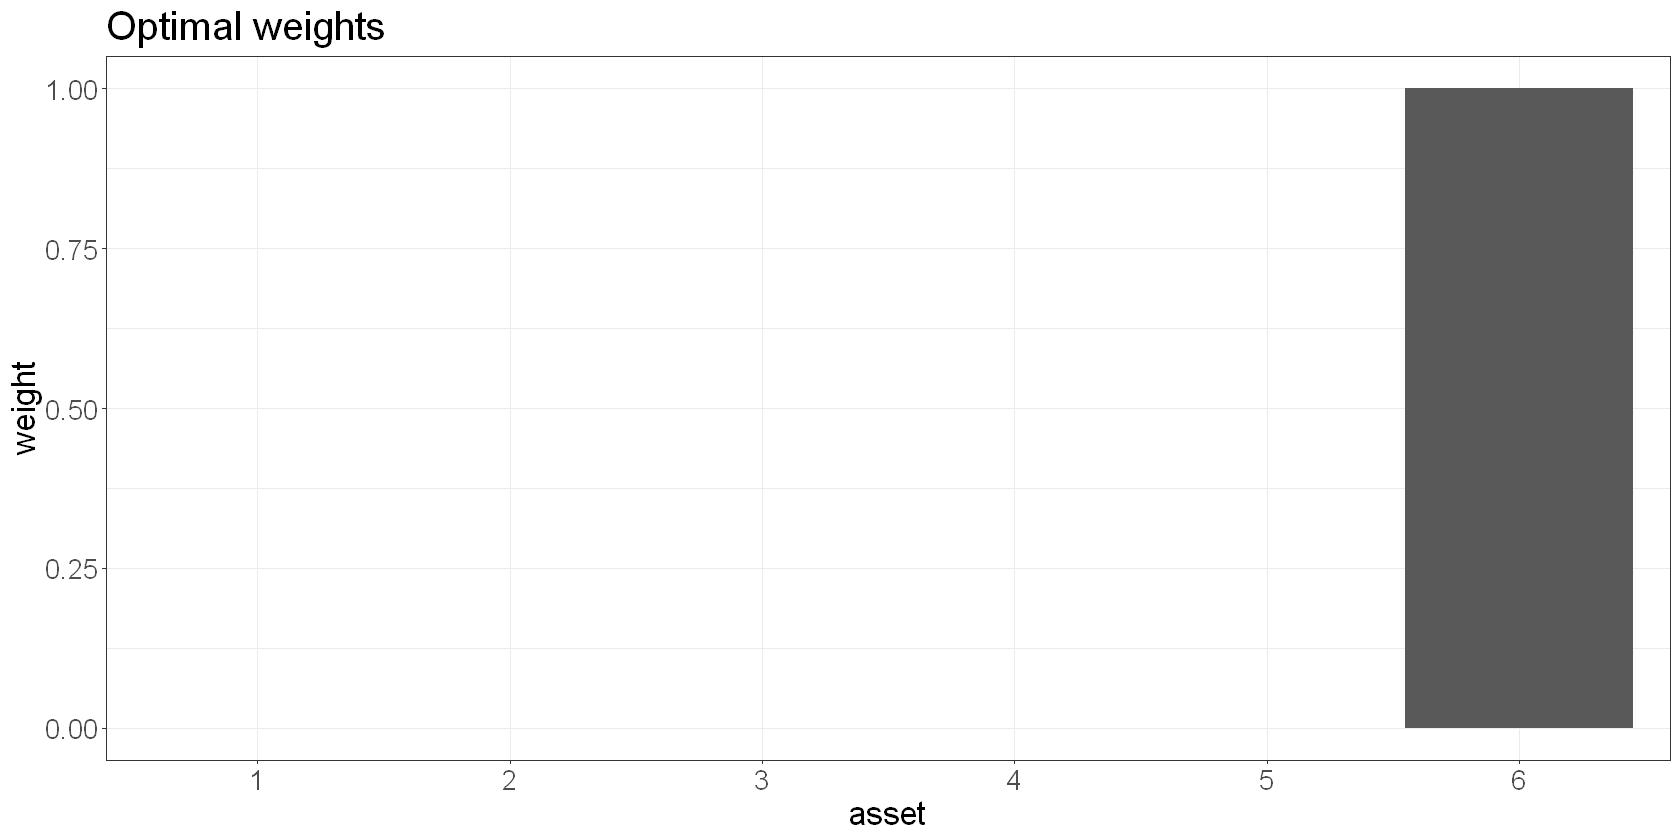

In [5]:
# vector of weights we expect the optimiser to find
expected_weights <- matrix(c(0, 0, 0, 0, 0, 1), ncol = 1)  # fully invested in highest expected return

weights1 <- maximise_returns(r1)
weights1

weights1 %>%
  as.data.frame() %>%
  ggplot(aes(x = factor(1:6), y = V1)) +
    geom_col() +
    labs(
      x = "asset",
      y = "weight",
      title = "Optimal weights"
    )

# check we got what we expected
all.equal(weights1, expected_weights, tolerance = 1e-9)

You can see that the optimiser did indeed go all in on asset 6. Also notice that the other weights go extremely close, but not precisely to zero. That's because the optimiser uses a numerical method rather than a precise analytical solution to solve the problem. 

Let's verify the long-only constraint. We'll set asset 6's return to be -0.006. We could now maximise our expected portfolio returns by assigning 100% of our position to a short on this asset. But since we have a long-only constraint, this asset should be assigned a zero weight, and asset 5 (expected return 0.005) should get 100% of our weight:

[1]  0.001  0.002  0.003  0.004  0.005 -0.006

1.833225e-16
1.190608e-16
-2.071393e-16
-1.427314e-16
1.000074e+00
-1.191854e-16


[1] "Mean relative difference: 7.402931e-05"

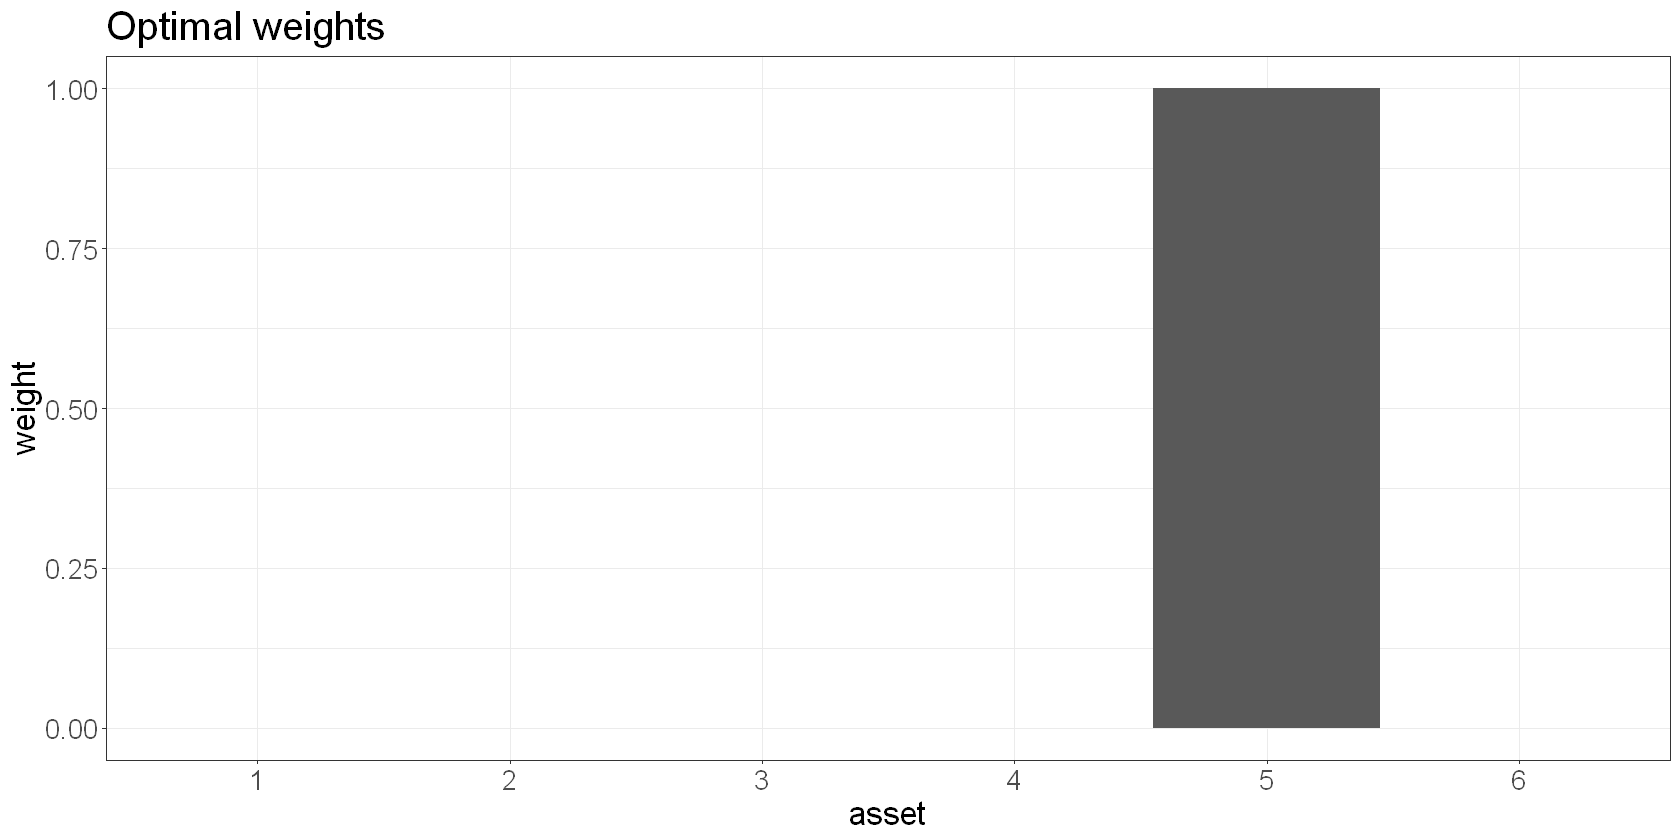

In [6]:
# vector of expected returns
r1a <- r1*c(rep(1, 5), -1)
r1a

# vector of weights we expect the optimiser to find
expected_weights <- matrix(c(0, 0, 0, 0, 1, 0), ncol = 1)  # fully invested in highest expected return

weights1a <- maximise_returns(r1a)
weights1a

weights1a %>%
  as.data.frame() %>%
  ggplot(aes(x = factor(1:6), y = V1)) +
    geom_col() +
    labs(
      x = "asset",
      y = "weight",
      title = "Optimal weights"
    )

# check we got what we expected
all.equal(weights1a, expected_weights, tolerance = 1e-9)

You can see that the optimiser did indeed find an optimal weight of 100% for asset 5 and 0% for everything else. 

### Maximise expected return given costs and our initial position

The next problem is slightly more complex and starts to reflect what we would think about in the trading problem - maximising our expected return subject to transaction costs, given our existing position.

Imagine you have three assets A, B, and C with the following expected returns:
- A: 0.002
- B: 0.001
- C: 0.001

So you buy asset A in an effort to maximise expected returns. 

Now things change and you update your forecasts for your three assets:
- A: 0.002
- B: 0.0025
- c: 0.001

If it didn't cost anything to trade, you would switch to asset B. But say it costs you 5 basis points (0.0005) to trade. In this scenario, your costs wipe out your additional expected returns. Suddenly, there's no benefit to switching, so you stay in asset A. 

Our problem is now *"Given these expected returns and these existing positions, and these costs of trading, what are my optimal weights in the next period?*

Here's a function for framing and solving that problem with CVXR, assuming fixed percentage costs (retaining our no-leverage and long-only constraints):

In [7]:
maximise_alpha_with_costs <- function(expected_returns, current_weights, costs) {
  # define our weights vector as a CVXR::Variable
  weights <- Variable(rows = length(expected_returns))
  # define an alpha term as the weighted sum of expected returns
    # again, express using linear algebra
  alpha_term <- (t(weights) %*% expected_returns)
  # define a costs term. depends on:
    # cost of trading - needs to be expressed such that it scales with expected returns
      # calculate as elementwise cost * absolute value of weights - current_weights
      # use CVXR::multiply and CVXR::abs
    # absolute distance of current_weights to our weights variable
      # the more our target weights differ from current weights, the more it costs to trade
      # this is a decent representation of fixed percentage costs, but doesn't capture minimum commissions
    # sum_entries is a CVXR function for summing the elements of a vector
  costs_term <- sum_entries(multiply(costs, abs(weights - current_weights))) # elementwise abs, multiply
  # now our portfolio expected returns can be modelled as our alpha term less our costs
  # and our objective is to maximise this expression
  objective <- Maximize(alpha_term - costs_term)
  # we'll keep our no leverage constraint - sum of the abs.values of the weights must be less than or equal to 1
  # also keep our long only constraint
  constraints <- list(cvxr_norm(weights, 1) <= 1, weights >= 0)
  # specify our problem
  problem <- Problem(objective, constraints)
  # solve it
  result <- solve(problem)

  # return the weights vector that CVXR found
  result$getValue(weights)
}

Now we set our expected returns for the next period, our current weights, and our costs. 

We'll start off 100% invested in asset 6. But in the next period, we predict asset 5 to return 5 basis points more than asset 6. But we'll set our costs to 5 basis points, and thus expect the optimiser to return our existing positions (ie do no trading in the next period):

2.791983e-15
0.000000e+00
0.000000e+00
0.000000e+00
1.142232e-15
9.999862e-01


[1] "Mean relative difference: 1.375717e-05"

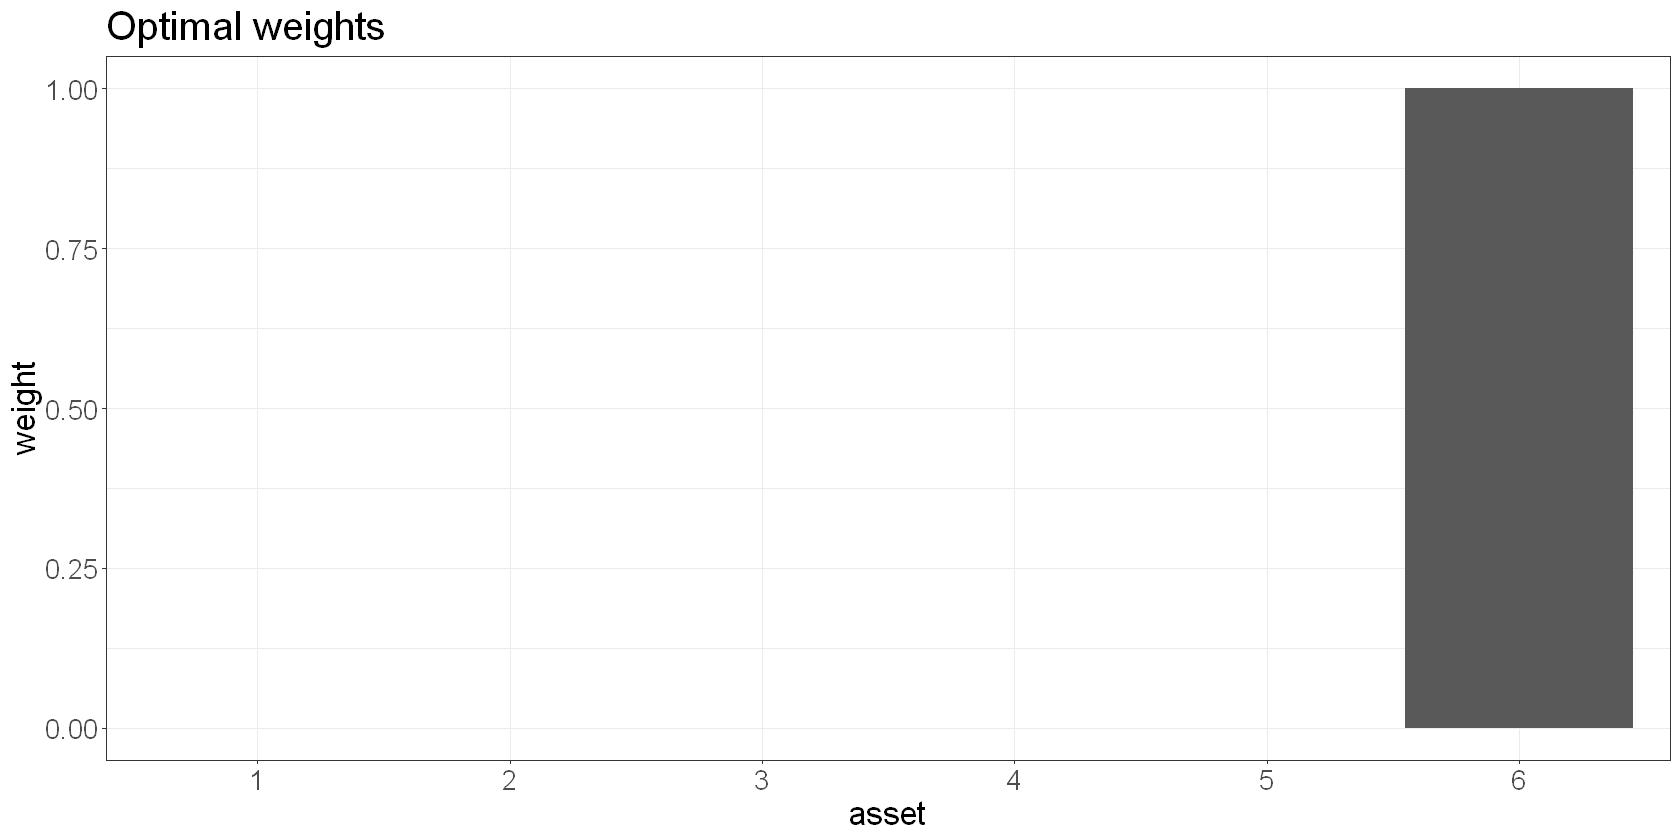

In [8]:
# two assets with high expected returns, existing position in one.
# expect that adding transaction costs causes us not to switch out of existing position.
expected_returns <- c(0, 0, 0, 0, 0.0025, 0.002)
w0 <- c(0, 0, 0, 0, 0, 1)
costs <- 5/10000  # costs expressed roughly scaled to expected returns
expected_weights <- matrix(w0, ncol = 1)  # shouldn't switch

weights2 <- maximise_alpha_with_costs(expected_returns, w0, costs)
weights2

weights2 %>%
  as.data.frame() %>%
  ggplot(aes(x = factor(1:6), y = V1)) +
    geom_col() +
    labs(
      x = "asset",
      y = "weight",
      title = "Optimal weights"
    )

all.equal(weights2, expected_weights, tolerance = 1e-9)

Nice. Again we got the result we expected.  

An important point here is the concept of "certain costs versus uncertain expected returns." 

I don't mean "uncertain" in the probabilistic sense (realising the expected return in the long term despite random variation in the short term). I mean that there's a chance we overestimate our expected returns - either from biases introduced in the modelling process, alpha decay, increasing market efficiency, or something else.

Since our costs are certain, but our edge is uncertain, we might want to artificially inflate the hurdle we need to overcome to trigger us to trade. We can do this by introducing a coefficient on the costs term corresponding to our "propensity to trade." More on this below. 

### Markowitz (mean-variance) optimisation without costs

Markowitz or mean-variance optimisation incorporates a penalty for risk. Typically we use a covariance matrix to model our risks - we want lower weights on things that tend to move together, because in the extreme it's like having two of the same thing in the portfolio (in this case, risk is narrowly defined as portfolio volatility).

Note that we use our *assumed* or *forecast* covariance matrix going forward - how we estimate this can be a significant source of error. Usually we shrink it towards long-term values or zeros to reflect uncertainty in our estimates.

Under this framework, we're essentially asking the question *"Which portfolio weights maximise my return for a given level of expected portfolio volatility, given these expected returns, and these asset co-movements?"* 

We seek to maximise the weighted sum of portfolio returns less a penalty term for risk - which in this case we define as portfolio variance (how much our portfolio returns wiggle around). Portfolio variance is calculated as $w^T \Sigma w$ (the transpose of the weight vector multiplied by the covariance matrix multiplied by the weight vector, where "multiplied by" == the dot product).

We add a coefficient lambda ($\lambda$) which represents how much risk we'd like to take on. A higher lambda will put a bigger penalty on the risk term and change the weights accordingly.

So now we seek the weight vector $w$ that maximises:

$
w^T R - \lambda w^T \Sigma w
$

Here's a function for framing and solving this problem with CVXR, retaining our no-leverage and long-only constraints:

In [9]:
mvo <- function(expected_returns, covmat, lambda = 1) {
  # define our weights vector as a CVXR::Variable
  weights <- Variable(length(expected_returns))
  # define an alpha term as the weighted sum of expected returns
    # again, express using linear algebra
  alpha_term <- (t(weights) %*% expected_returns)
  # define a risk term as w*Sigma*w
    # quad_form is a CVXR function for doing w*Sigma*w
  risk_term <- quad_form(weights, covmat)
  # define our object
    # maximise our alpha less our risk term multiplied by some factor, lambda
  objective <- Maximize(alpha_term - lambda*risk_term)
  # apply our no leverage and long only constraints
  constraints <- list(cvxr_norm(weights, 1) <= 1, weights >= 0)
  # specify the problem
  problem <- Problem(objective, constraints)
  # solve
  result <- solve(problem)

  # return the values of the variable we solved for
  result$getValue(weights)
}

We'll give all six assets the same expected return of 0.01.  

And we'll give all our pairs of assets a covariance of zero (meaning that they're uncorrelated with one another), but we'll give assets 5 and 6 a slightly higher covariance so that they noisily move together.

Finally, we'll give all the assets the same variance (the term on the diagonal in the covariance matrix). 

Under this scenario, we would expect assets 1-4 to get the same weight. But we would expect assets 5 and 6 to be slightly down-weighted because they're somewhat similar. 

In [10]:
# 6 assets with equal expected returns
expected_returns <- rep(0.01, 6)

# give all assets except 5 and 6 a covariance of zero
# give assets 5 and 6 a larger covariance
# and set each asset's variance to the same value
covmat <- diag(6)
covmat[5, 6] <- covmat[6, 5] <- 0.5

expected_returns
covmat

[1] 0.01 0.01 0.01 0.01 0.01 0.01

1,0,0,0,0.0,0.0
0,1,0,0,0.0,0.0
0,0,1,0,0.0,0.0
0,0,0,1,0.0,0.0
0,0,0,0,1.0,0.5
0,0,0,0,0.5,1.0


0.1875
0.1875
0.1875
0.1875
0.1250
0.1250


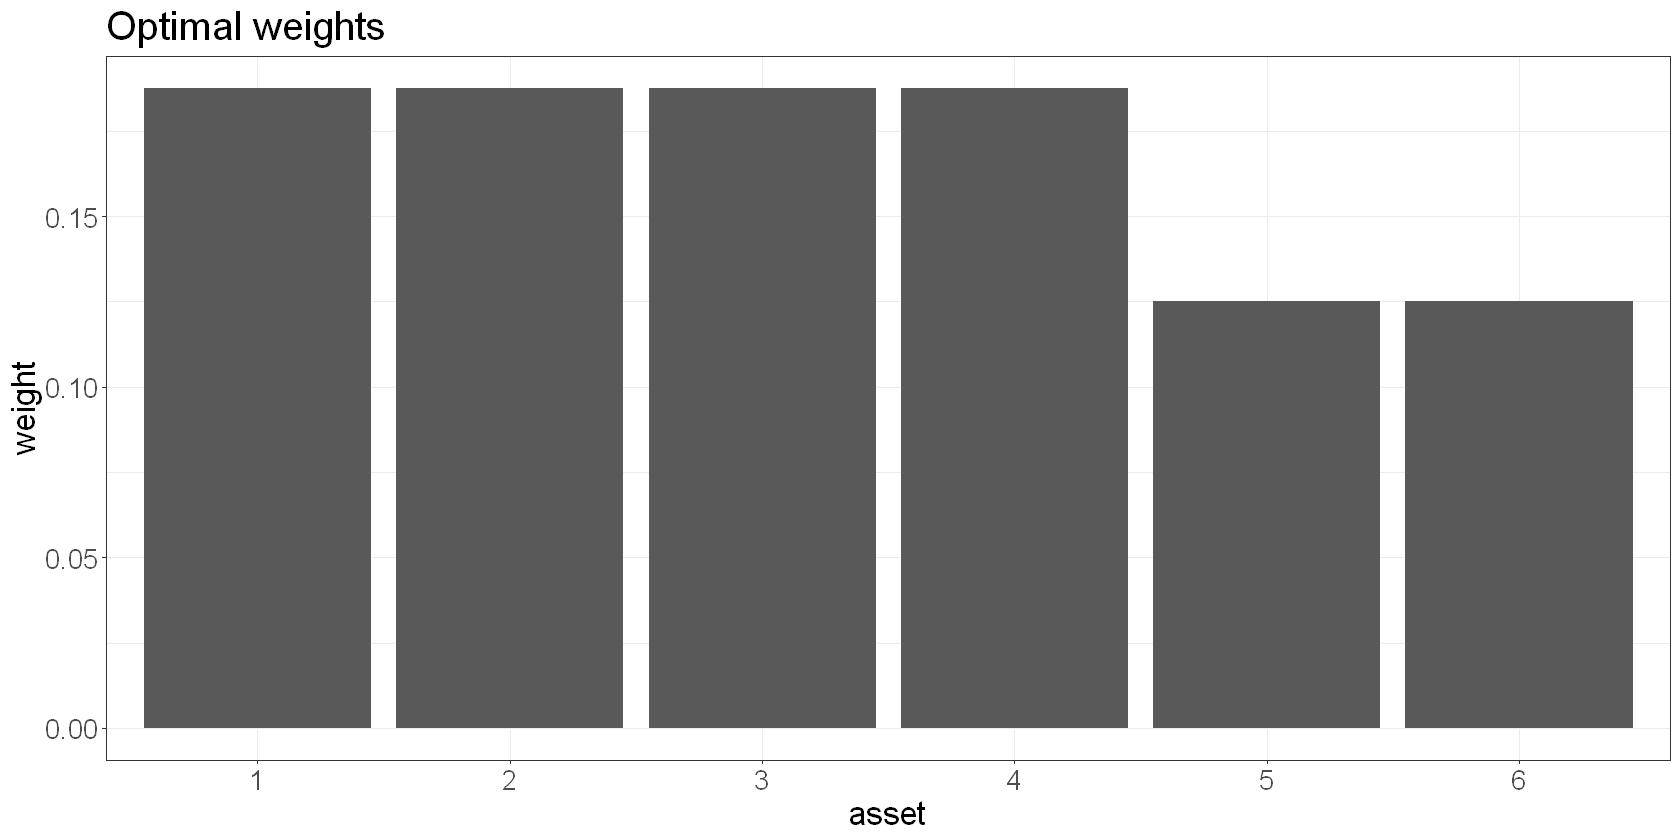

In [11]:
# we expect to go equal weight into assets 1-4 and have a lower weight on assets 5 and 6 due to their co-movement
weights3 <- mvo(expected_returns, covmat, lambda = 0.01)

weights3

weights3 %>%
  as.data.frame() %>%
  ggplot(aes(x = factor(1:6), y = V1)) +
    geom_col() +
    labs(
      x = "asset",
      y = "weight",
      title = "Optimal weights"
    )

Perfect. The optimiser correctly diversified the portfolio to minimise portfolio variance by taking into account the co-movement of assets 5 and 6, while maximising expected returns. 

It's also illustrative to look at the effect of higher asset-wise variances. 

We'll progressively increase the variance of assets 1 through 6 so that asset 1 has the lowest variance and asset 6 has the highest. 

Since we're seeking to maximise expected returns and minimise risk, we would expect the optimiser to prefer the assets with the lower volatilities. That is, we'd expect asset 1 to get the highest weight and asset 6 to get the lowest. Since assets 5 and 6 move noisily together, we'd expect these to be down-weighted more than the others. 

In [12]:
# 6 assets with equal expected returns
expected_returns <- rep(0.01, 6)

# give all assets except 5 and 6 a covariance of zero
# give assets 5 and 6 a larger covariance
# and set each asset's variance to a larger value
covmat <- diag(6)*(seq(1.1, 1.6, by = 0.1))
covmat[5, 6] <- covmat[6, 5] <- 0.5

expected_returns
covmat

[1] 0.01 0.01 0.01 0.01 0.01 0.01

1.1,0.0,0.0,0.0,0.0,0.0
0.0,1.2,0.0,0.0,0.0,0.0
0.0,0.0,1.3,0.0,0.0,0.0
0.0,0.0,0.0,1.4,0.0,0.0
0.0,0.0,0.0,0.0,1.5,0.5
0.0,0.0,0.0,0.0,0.5,1.6


0.2163119
0.1982859
0.1830332
0.1699594
0.1217383
0.1106712


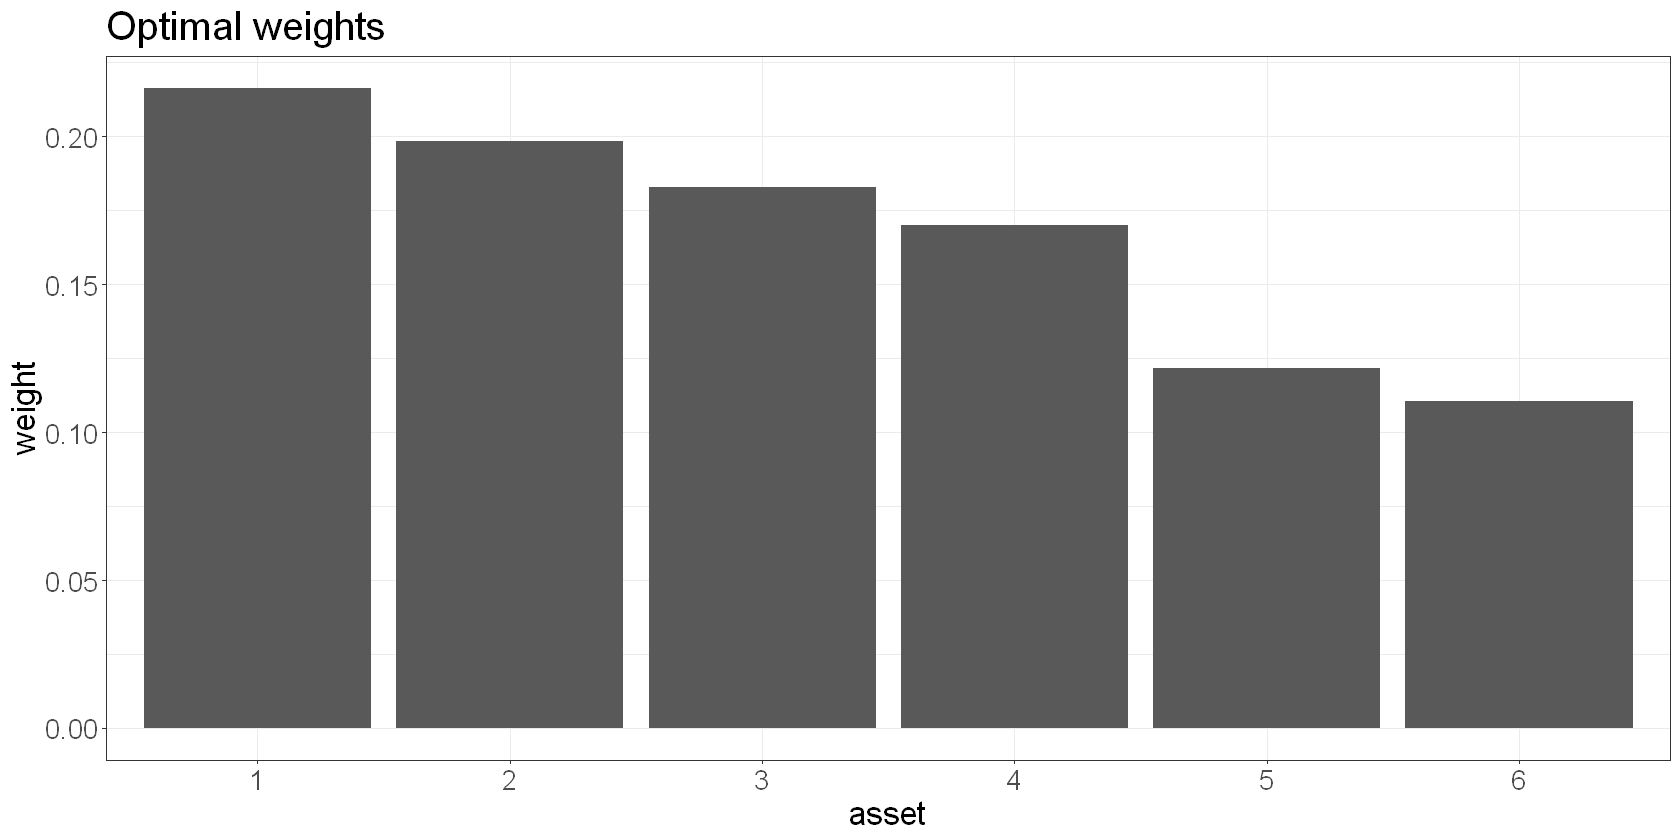

In [13]:
# we expect to go equal weight into assets 1-4 and have a lower weight on assets 5 and 6 due to their co-movement
weights3 <- mvo(expected_returns, covmat, lambda = 0.01)

weights3

weights3 %>%
  as.data.frame() %>%
  ggplot(aes(x = factor(1:6), y = V1)) +
    geom_col() +
    labs(
      x = "asset",
      y = "weight",
      title = "Optimal weights"
    )

You can see how the optimiser now takes into account the increasing variances by up-weighting the lower-variance assets.

## Explore the impact of the lambda parameter
Next, we'll use MVO and explore different values of lambda. This time, we'll include assets with negative expected returns, but force the portfolio to be fully invested and long only. Our covariance matrix will be random (but we need to force symmetry and positive variances on the diagonal to match the real world). 

Remember that higher values of lambda will penalise assets that move together more. So:
- higher values of lambda should lead to more diversification due to the higher risk penalty.  
- lower values of lambda should lead to more concentration as we penalise risk less and seek the asset with the highest expected returns more aggressively

In [14]:
set.seed(503)

# define returns and covariances
num_assets <- 6
expected_returns <- rnorm(num_assets, 0, 0.1)
S <- matrix(rnorm(num_assets^2, 0, 0.1), nrow = num_assets, ncol = num_assets)
S <- t(S) %*% S  # make symmetric and positive variances on diagonal

expected_returns
S
isSymmetric(S)

[1]  0.03551251 -0.07788934 -0.07573570  0.23298006  0.02839749  0.12810252

0.0155231533,0.02012679,-0.0230124341,-0.0001158865,0.006316539,-0.0003914469
0.0201267875,0.06045292,-0.0132481650,-0.0192946840,0.010127719,-0.0185506516
-0.0230124341,-0.01324817,0.0721931391,0.0137559086,-0.019164521,0.0006967321
-0.0001158865,-0.01929468,0.0137559086,0.1004947030,-0.037670426,-0.0224346107
0.0063165389,0.01012772,-0.0191645212,-0.0376704259,0.025109511,0.0065522954
-0.0003914469,-0.01855065,0.0006967321,-0.0224346107,0.006552295,0.0397130317


[1] TRUE

We'll loop through different values of lambda, let the optimiser find our optimal weights, and calculate the resulting expected portfolio return and volatility. The end result will be a different set of weights and a different portfolio return and volatility for each value of lamda:

In [15]:
# define our optimisation problem inputs
weights <- Variable(num_assets)
portfolio_return <- t(expected_returns) %*% weights
portfolio_vol <- quad_form(weights, S)
constraints <- list(weights >= 0, sum(weights) == 1)  # long only...and force portfolio to be be fully invested

# lambdas
lambdas <- 10^seq(-2, 4, length.out = 100)

# allocate vectors for returns and volatilities
returns <- rep(0, length(lambdas))
vols <- rep(0, length(lambdas))
# allocate matrix for weight vectors
weight_vectors <- matrix(0, nrow = length(lambdas), ncol = num_assets)

# loop through lambdas and solve
for(i in seq_along(lambdas)) {
  lambda <- lambdas[i]
  obj <- Maximize(portfolio_return - lambda*portfolio_vol)
  problem <- Problem(obj, constraints)
  result <- solve(problem)

  # note can't get other variables back if we return `result` from our function, so do outside function call
  returns[i] <- result$getValue(portfolio_return)
  vols[i] <- result$getValue(sqrt(portfolio_vol))
  weight_vectors[i, ] <- result$getValue(weights)
}

Now we can plot the expected portfolio volatility and return for each value of lambda:

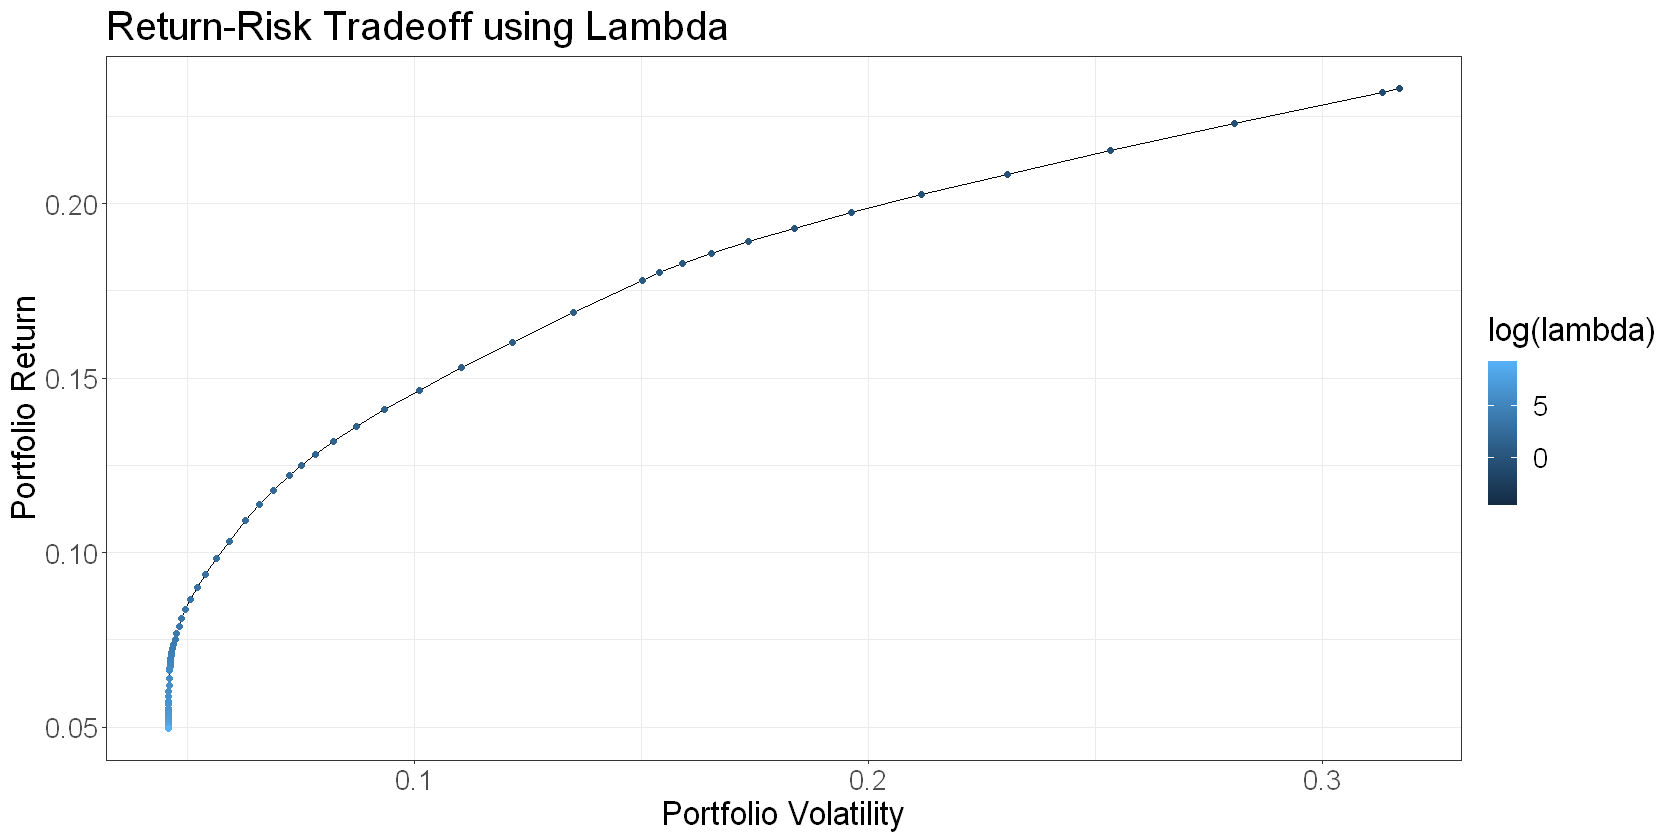

In [16]:
data.frame("portfolio_return" = returns, "portfolio_vol" = vols, "lambda" = lambdas) %>%
  ggplot(aes(x = portfolio_vol, y = portfolio_return)) +
  geom_line() +
  geom_point(aes(colour = log(lambda))) +
  labs(
    x = "Portfolio Volatility",
    y = "Portfolio Return",
    title = "Return-Risk Tradeoff using Lambda"
  )

You will recognise this as Markowitz's efficient frontier - we have found the weights that maximise return for a given volatility, or minimise volatility for a given return.

Each point on that frontier represents a different set of weights. Let's look at some of those weight vectors for different values of lambda:

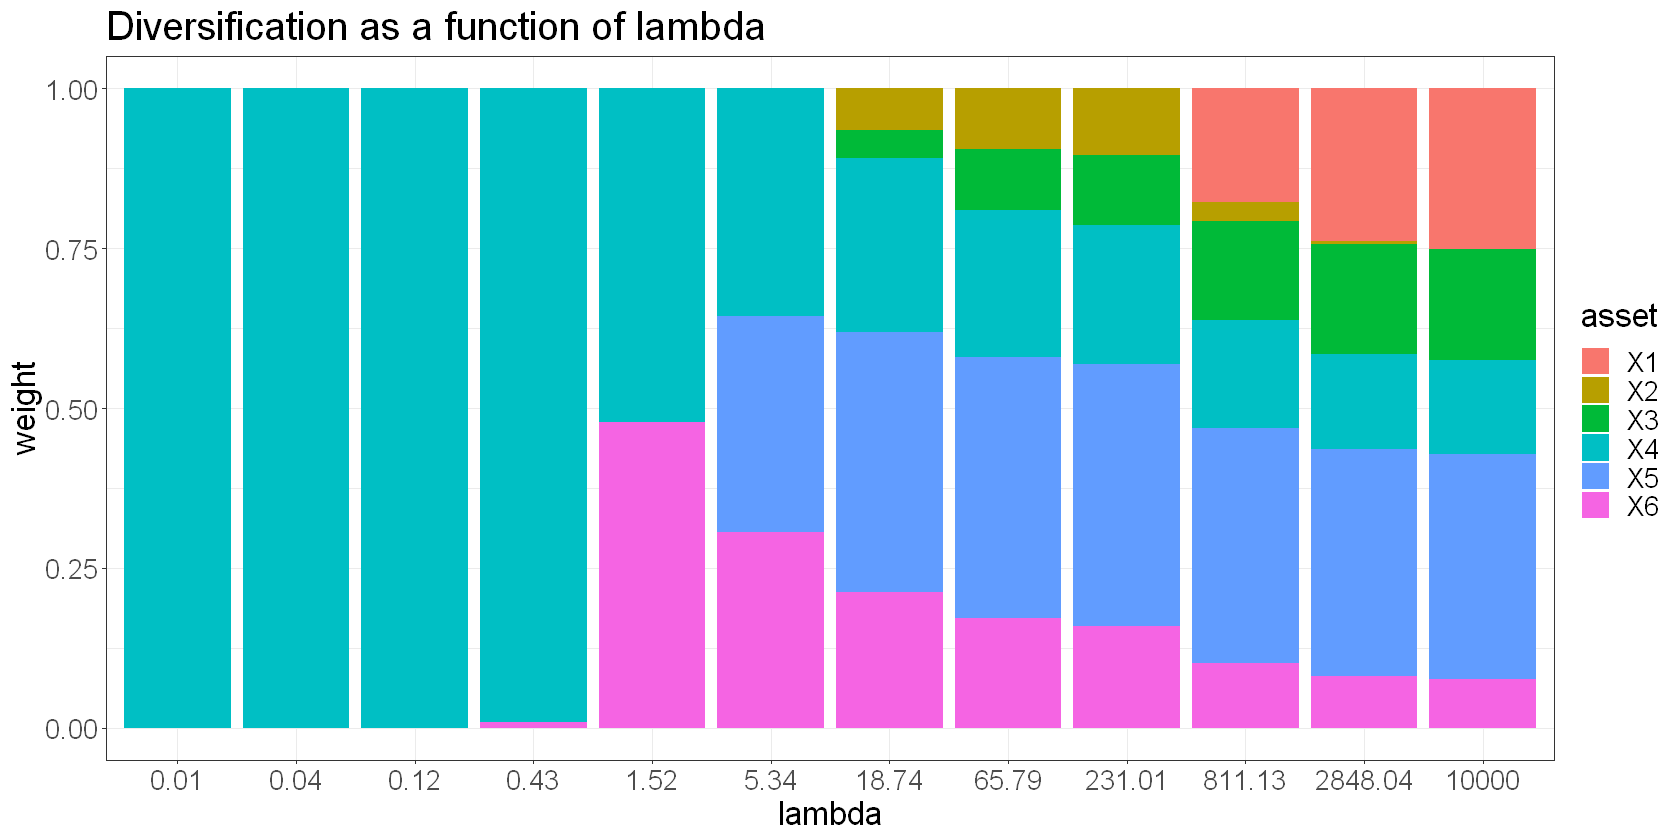

In [17]:
weight_vecs <- data.frame(weight_vectors, lambdas) %>%
  pivot_longer(-lambdas, names_to = "asset", values_to = "weight") %>%
  rename("lambda" = lambdas)

weight_vecs %>%
  filter(lambda %in% lambdas[seq(from = 1, to = length(lambdas), by = 9)]) %>%
  ggplot(aes(x = factor(round(lambda, 2)), y = weight, fill = asset)) +
    geom_col(position = "stack") +
    labs(
      x = "lambda",
      y = "weight",
      title = "Diversification as a function of lambda"
    )

You can see how the lambda parameter impacts diversification:

- Low values seek concentration in the assets with the highest expected returns (asset 4)
- Higher values force diversification into other assets with lower expected returns (we trade expected returns for more diversification and lower volatility)
- There is a limit to diversification and thus a minimum portfolio volatility given our covariance matrix and the fact that we force the portfolio to be fully invested:
    - We see this in the convergence of portfolio weights towards the right of the bar plot above.
    - This corresponds to the left-most part of the efficient frontier where it goes vertical.

## How about if we relax the long only and fully invested constraints?
If we repeat the above, but without the long only and fully invested constraints, we should see the lambda parameter force us into more extreme diversification and some short positions. In the extreme, as we increase lambda, the optimiser should prefer smaller target weights as a way to reduce the portfolio volatility beyond what can be achieved through diversification alone:

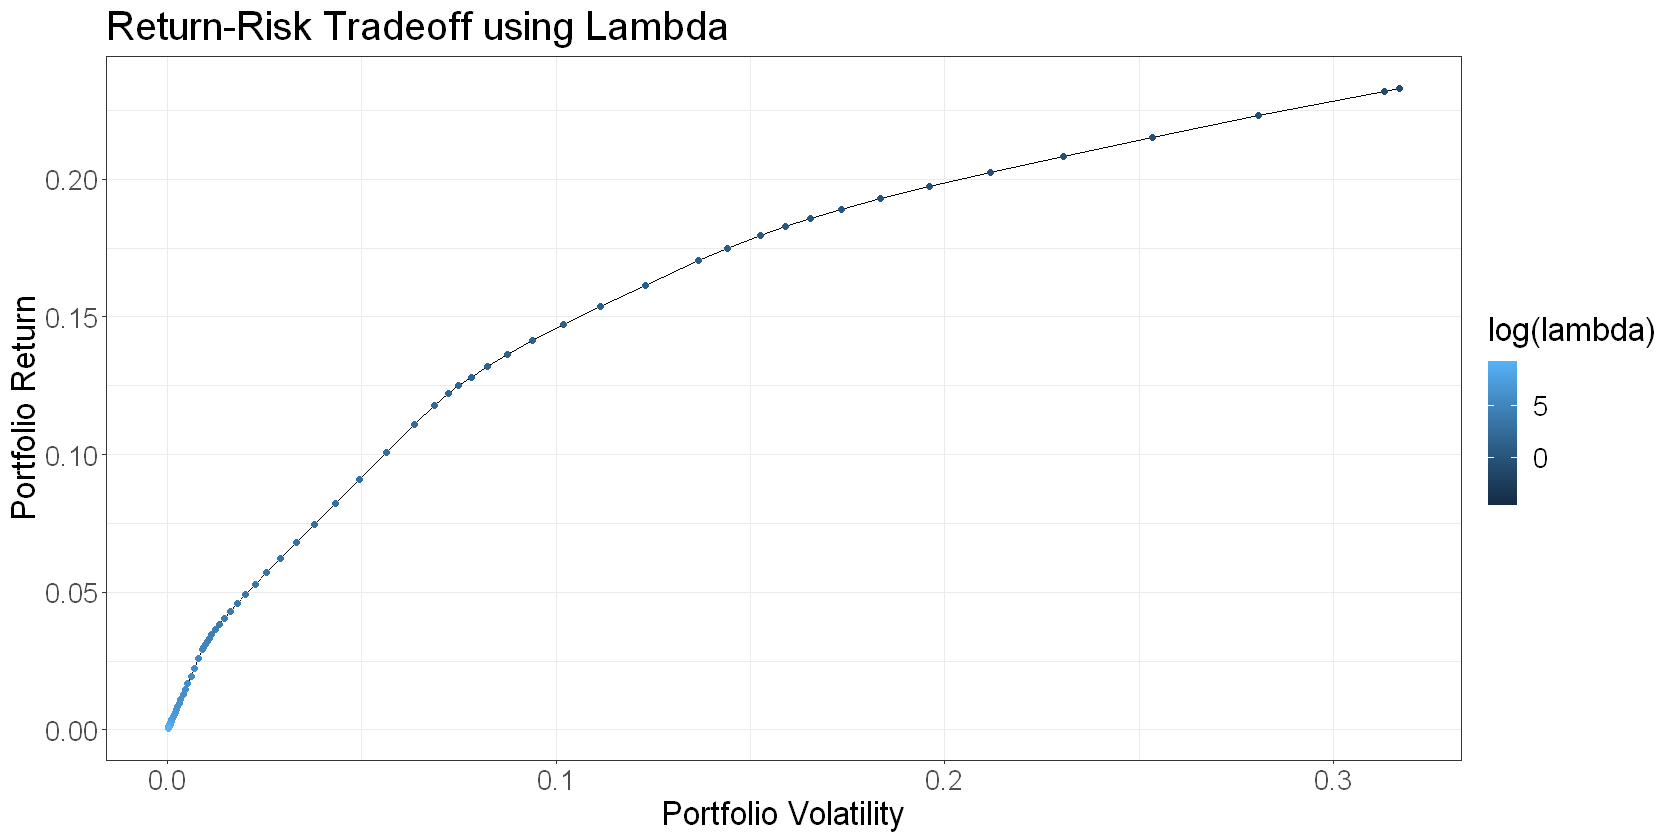

In [18]:
# replace our long only and fully invested constraint with leverage less than 1. Also allows negative weights.
constraints <- list(cvxr_norm(weights, 1) <= 1)

returns <- rep(0, length(lambdas))
vols <- rep(0, length(lambdas))
weight_vectors <- matrix(0, nrow = length(lambdas), ncol = num_assets)

for(i in seq_along(lambdas)) {
  lambda <- lambdas[i]
  obj <- Maximize(portfolio_return - lambda*portfolio_vol)
  problem <- Problem(obj, constraints)
  result <- solve(problem)

  returns[i] <- result$getValue(portfolio_return)
  vols[i] <- result$getValue(sqrt(portfolio_vol))
  weight_vectors[i, ] <- result$getValue(weights)
}

ggplot(
  data = data.frame("portfolio_return" = returns, "portfolio_vol" = vols, "lambda" = lambdas),
  aes(x = portfolio_vol, y = portfolio_return)
) +
  geom_line() +
  geom_point(aes(colour = log(lambda))) +
  labs(
    x = "Portfolio Volatility",
    y = "Portfolio Return",
    title = "Return-Risk Tradeoff using Lambda"
  )

We can see that under this different set of constraints, portfolio volatility can go all the way to zero. We would assume that that's because the optimiser is no longer forced to find a set of weights that has us fully invested, and that at some point it starts to reduce our position:

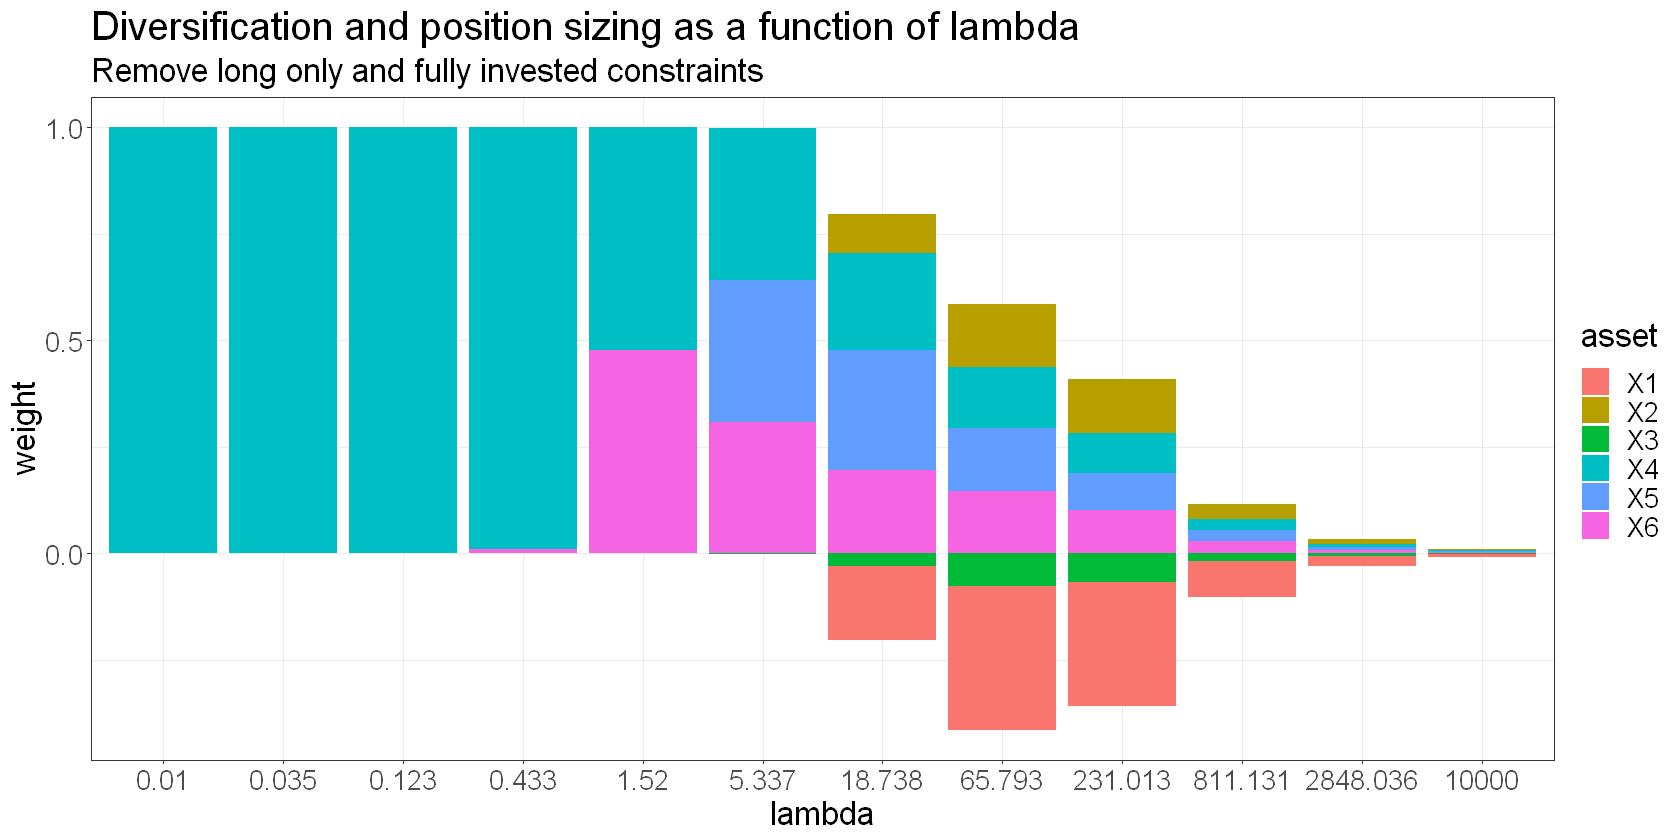

In [19]:
weight_vecs <- data.frame(weight_vectors, lambdas) %>%
  pivot_longer(-lambdas, names_to = "asset", values_to = "weight") %>%
  rename("lambda" = lambdas)

weight_vecs %>%
  filter(lambda %in% lambdas[seq(from = 1, to = length(lambdas), by = 9)]) %>%
  ggplot(aes(x = factor(round(lambda, 3)), y = weight, fill = asset)) +
    geom_col(position = "stack") +
    labs(
      x = "lambda",
      y = "weight",
      title = "Diversification and position sizing as a function of lambda",
      subtitle = "Remove long only and fully invested constraints"
    )

So you can start to see the interplay of the constraints, the alpha term, and the risk term (including the lambda coefficient). 
- At low values of lambda, we simply target the asset with the highest expected returns (asset 4) with little to no regard for portfolio volatility. 
- At a value of lambda of about 0.45, the diversification provided by a position in asset 6 is worth another reduction in expected returns. 
- At a value of about 5, the additional diversification from asset 5 is worth another reduction in expected returns. 
- At about 18, the additional diversification provided by a short position in asset 1 is worth another reduction in expected returns. 
- At about 60, the optimser starts to reduce the overall position of the portfolio. 
- From that point onwards, portfolio positions are reduced further and further, until in the extreme they're essentially zero. 

## MVO with costs

Our final example adds the cost term to the mean-variance optimisation problem. 

We introduce a new parameter, tau, a coefficient on our costs term that controls our "propensity to trade" in a similar way to how lambda controls our risk aversion.

For simplicity, we'll include our no-leverage and long-only constraints.

Our question now becomes *"Given my existing positions, these expected returns, these forecast covariances, these costs to trade, my risk aversion and my propensity to trade, as well as my constraints (long only, no leverage), what is the best set of weights for the next period?"*

We can write this as an optimisation problem:

Find the weights, $w$ that maximise:

$
w^T R - \lambda w^T \Sigma w - \tau c|{w - w_0}|
$

where $w_0$ is our initial weights and $c$ is our cost term.

Here's how we frame that problem in CVXR:


In [20]:
mvo_with_costs <- function(expected_returns, current_weights, costs, covmat, lambda = 1, tau=1) {
  # define our weights vector as a CVXR::Variable
  weights <- Variable(length(expected_returns))
  # define an alpha term as the weighted sum of expected returns
    # again, express using linear algebra
  alpha_term <- (t(weights) %*% expected_returns)
  # define a costs term. depends on:
    # cost of trading - needs to be expressed such that it scales with expected returns
      # calculate as elementwise cost * absolute value of weights - current_weights
      # use CVXR::multiply and CVXR::abs
    # absolute distance of current_weights to our weights variable
      # the more our target weights differ from current weights, the more it costs to trade
      # this is a decent representation of fixed percentage costs, but doesn't capture minimum commissions
    # sum_entries is a CVXR function for summing the elements of a vector
  costs_term <- sum_entries(multiply(costs, abs(weights - current_weights))) # elementwise abs, multiply
  # define a risk term as w*Sigma*w
    # quad_form is a CVXR function for doing w*Sigma*w
  risk_term <- quad_form(weights, covmat)
  # define our objective
    # maximise our alpha less our risk term multiplied by some factor, lambda, less our costs term multiplied by tau
  objective <- Maximize(alpha_term - lambda*risk_term - tau*costs_term)
  # apply our no leverage and long only constraints
  constraints <- list(cvxr_norm(weights, 1) <= 1, weights >= 0)
  # specify the problem
  problem <- Problem(objective, constraints)
  # solve
  result <- solve(problem)

  # return the values of the variable we solved for
  result$getValue(weights)
}

We'll use our expected returns and covariance matrix from last time:

In [21]:
# use our expected returns and cov mat from last time
expected_returns
S

[1]  0.03551251 -0.07788934 -0.07573570  0.23298006  0.02839749  0.12810252

0.0155231533,0.02012679,-0.0230124341,-0.0001158865,0.006316539,-0.0003914469
0.0201267875,0.06045292,-0.0132481650,-0.0192946840,0.010127719,-0.0185506516
-0.0230124341,-0.01324817,0.0721931391,0.0137559086,-0.019164521,0.0006967321
-0.0001158865,-0.01929468,0.0137559086,0.1004947030,-0.037670426,-0.0224346107
0.0063165389,0.01012772,-0.0191645212,-0.0376704259,0.025109511,0.0065522954
-0.0003914469,-0.01855065,0.0006967321,-0.0224346107,0.006552295,0.0397130317


Given a tau of zero (meaning we disgregard costs altogether) and a lambda of 15, we get the following weights for the next period:

-6.530549e-07
5.589699e-02
2.541301e-02
2.866296e-01
4.041310e-01
2.278091e-01


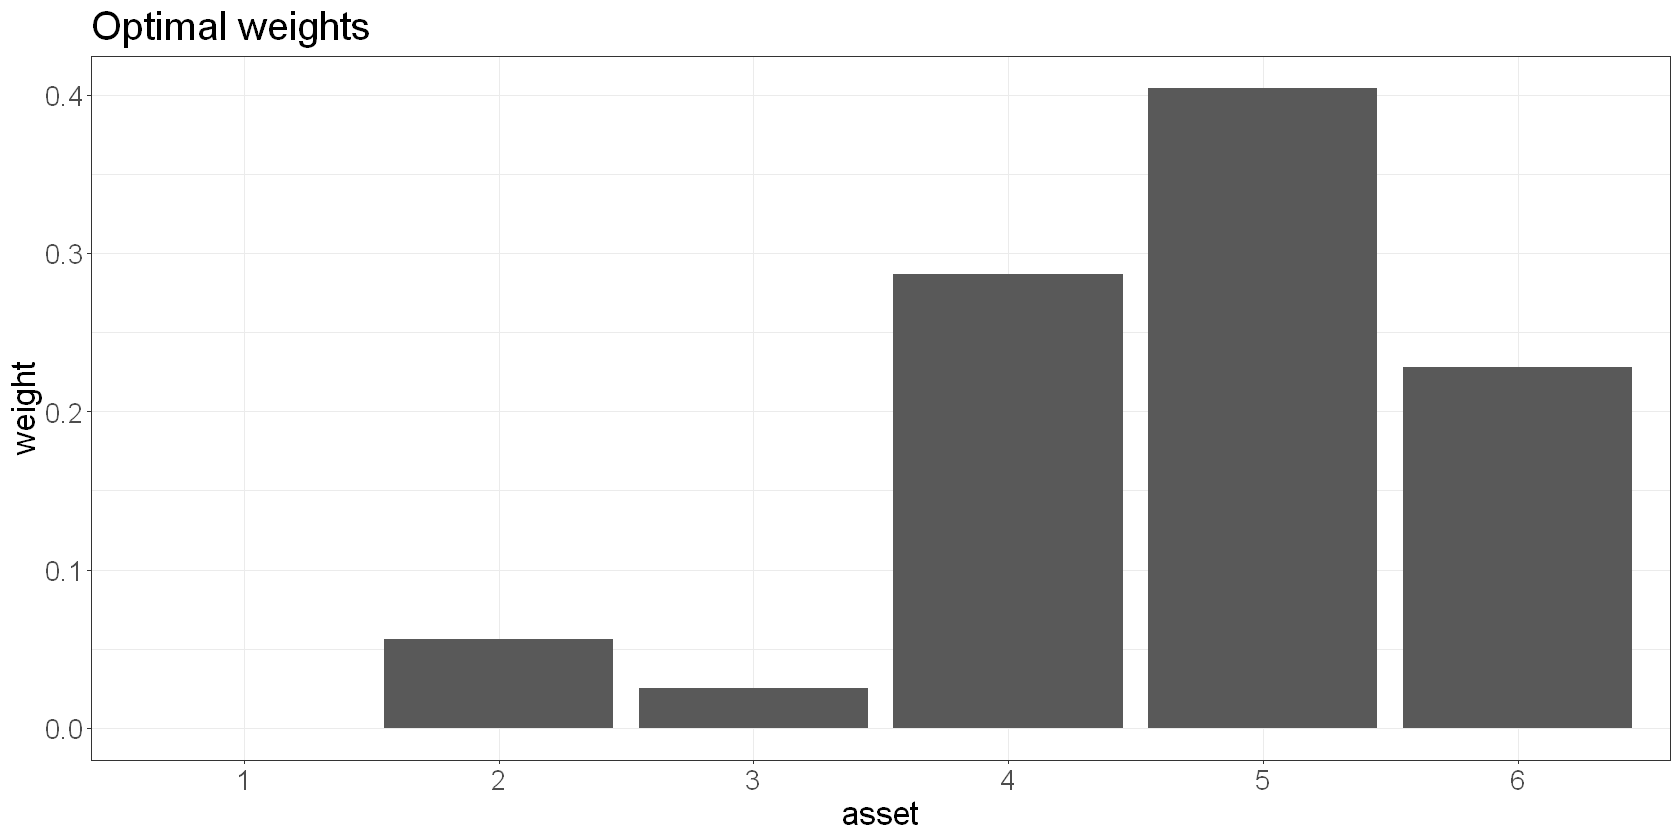

In [22]:
# define our existing positions - we're in the asset with the second highest expected returns
w0 <- c(0, 0, 0, 0, 0, 1)
costs <- 5/10000  # costs expressed roughly scaled to expected returns

# set lambda and tau
lambda <- 15
tau <- 0

weights4 <- mvo_with_costs(expected_returns, w0, costs, S, lambda = lambda, tau = tau)
weights4

weights4 %>%
  as.data.frame() %>%
  ggplot(aes(x = factor(1:6), y = V1)) +
    geom_col() +
    labs(
      x = "asset",
      y = "weight",
      title = "Optimal weights"
    )

Let's see what happens as we increase tau. We'll hold lambda constant at 15. 

In [23]:
# taus
taus <- 10^seq(0.5, 4, length.out = 20)

# allocate vectors for returns and volatilities
returns <- rep(0, length(lambdas))
vols <- rep(0, length(lambdas))
# allocate matrix for weight vectors
weight_vectors <- matrix(0, nrow = length(taus), ncol = num_assets)

# loop through lambdas and solve
for(i in seq_along(taus)) {
  tau <- taus[i]
  weight_vectors[i, ] <- mvo_with_costs(expected_returns, w0, costs, S, lambda = lambda, tau = tau)
}

Here's a plot of our next-period weights for different values of tau:

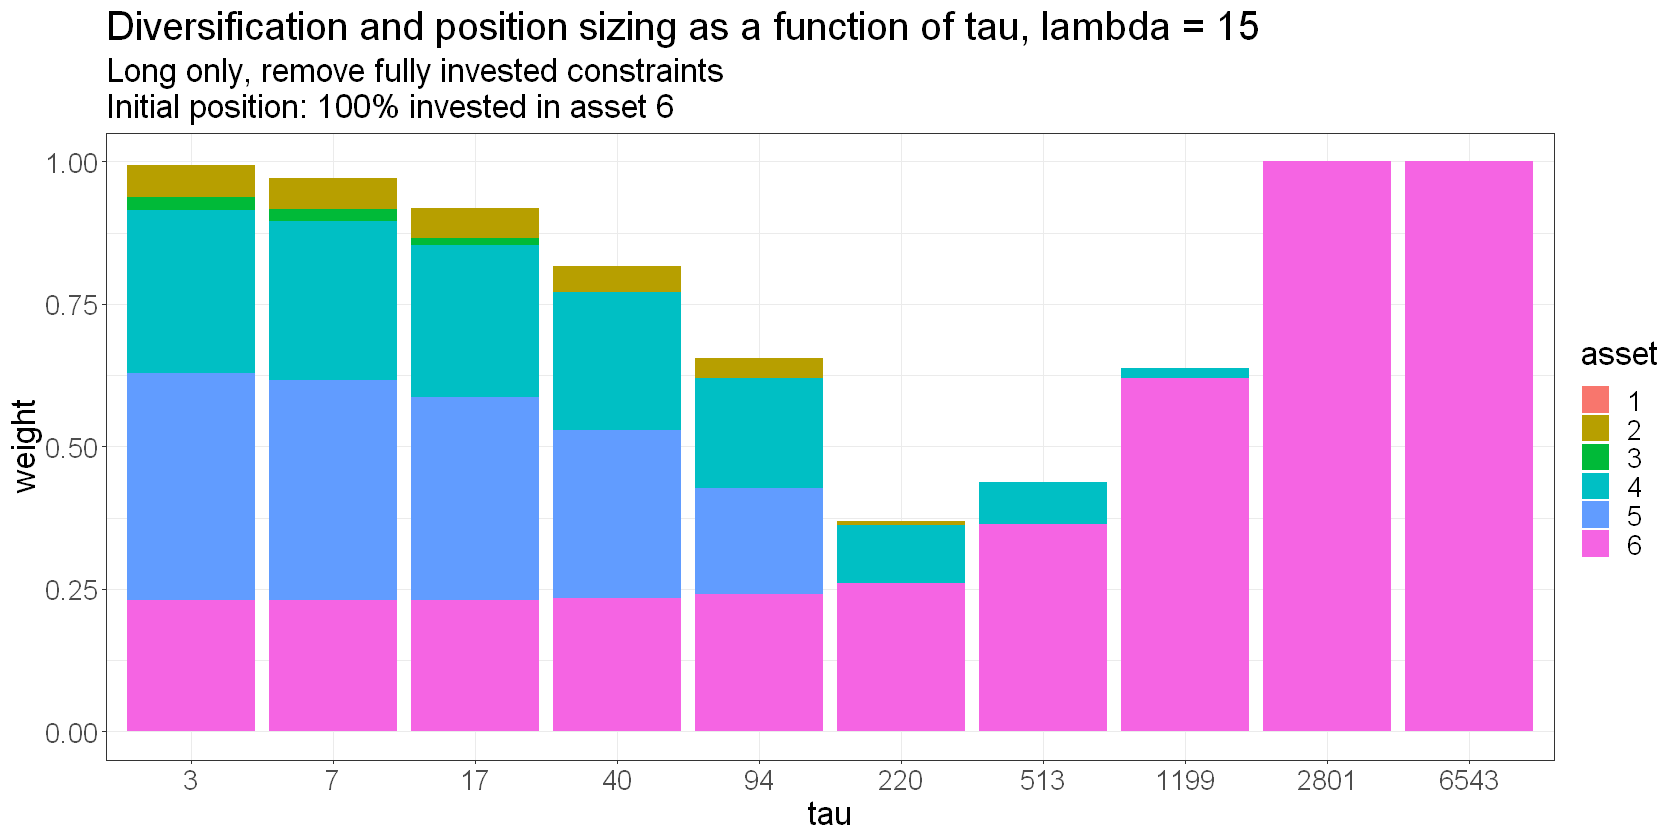

In [24]:
weight_vecs <- data.frame(weight_vectors, taus) %>% 
  rename_with(~gsub("X", "", .x)) %>% 
  pivot_longer(-taus, names_to = "asset", values_to = "weight") %>%
  rename("tau" = taus) %>% 
  left_join(
    data.frame(asset = as.character(c(1:6)), starting_weight = w0),
    by = "asset"
  )%>% 
  mutate(pos_delta = weight - starting_weight)

weight_vecs %>%
  filter(tau %in% taus[seq(from = 1, to = length(taus), by = 2)]) %>%
  ggplot(aes(x = factor(round(tau, 0)), y = weight, fill = asset)) +
    geom_col(position = "stack") +
    labs(
      x = "tau",
      y = "weight",
      title = glue::glue("Diversification and position sizing as a function of tau, lambda = {lambda}"),
      subtitle = "Long only, remove fully invested constraints\nInitial position: 100% invested in asset 6"
    )

This plot shows the actual trading required for each asset as a proportion of invested capital (negative values imply selling an asset):

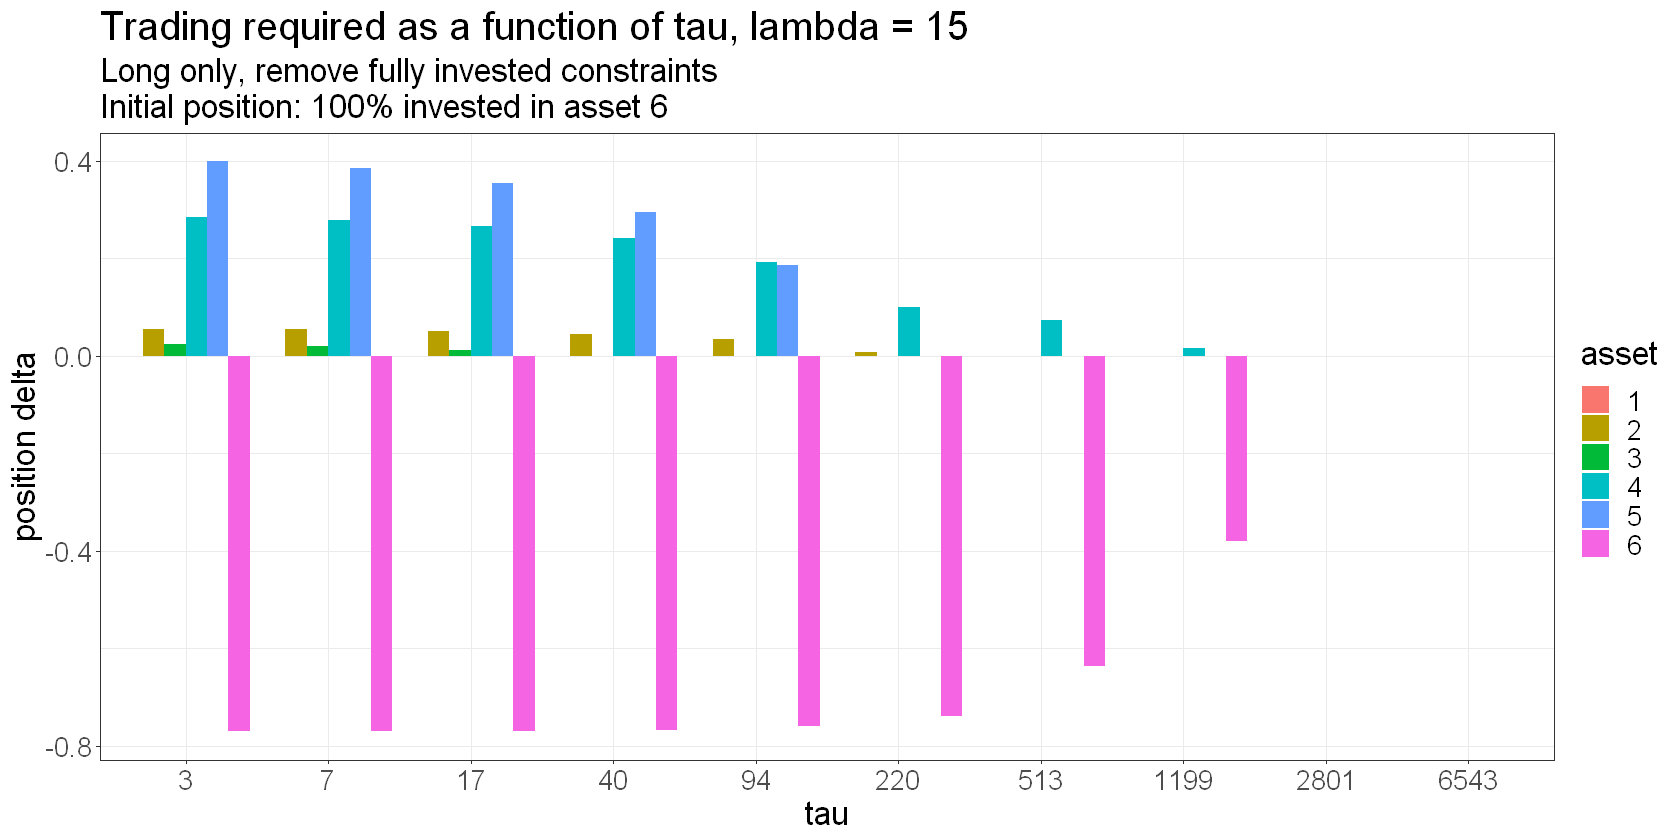

In [25]:
  weight_vecs %>%
  filter(tau %in% taus[seq(from = 1, to = length(taus), by = 2)]) %>%
  ggplot(aes(x = factor(round(tau, 0)), y = pos_delta, fill = asset)) +
    geom_col(position = "dodge") +
    labs(
      x = "tau",
      y = "position delta",
      title = glue::glue("Trading required as a function of tau, lambda = {lambda}"),
      subtitle = "Long only, remove fully invested constraints\nInitial position: 100% invested in asset 6"
    )

You can see that for smaller values of tau, we pay less attention to costs and make more and bigger trades. We sell a big chunk of asset 6 and buy varying amounts of the other assets. 

As we increase tau, our target weights start to differ less from our starting weights, until we do no trading at all and our next position is equal to our current position.

You can see how, under this framework, the behaviour of your strategy is controlled by essentially two levers: lambda and tau. You would find appropriate values for these parameters through simulation, similarly to how we found an appropriate value for our no-trade buffer in previous articles. We'll do that in the next article. 

## Some tips and tricks

### Convex optimisation in context

It's important to understand that under this framework, estimating our expected returns and covariances is the whole game. The optimiser will always find the best weights given your expected returns and covariances, but it has no control over the *quality* of those estimates. That's up to you. 

Remember, convex optimisation isn't a source of alpha. It's just a tool to help you implement some trading rules to harness your alphas effectively. 

### CVXR tips and tricks

Here are some general tips and tricks to be aware of when setting up optimisation problems with CVXR:

- <= and >= problems can generally be solved by CVXR
- but > and < problems may not be strictly convex (and hence CVXR won't converge)
- if you get errors, it's often because you didn't specify a linear algebra problem correctly (check you've transposed the correct vector or matrix and used the correct operator)
- look through the lst of CVXR functions - it is incredibly rich
- CVXR will fall over if you covariance matrix isn't symmetrical and positive semi definite, sometimes even if it is out just a touch, so it's wise to put a check on your covariance matrix before proceeding with the optimisation.

## Bonus: constrain historical downside risk

I got this idea from Scott Sanderson back in the Quantopian days. 

In what we've seen so far, our weights are dependent on expected return and covariance estimates (as well as constraints, costs, etc).

Estimating covariances is, unfortunately, famously difficult. And the weights our optimiser returns will be very sensitive to the covariance values you input (as an exercise, experiment by changing one or more values in the covariance matrixes of previous examples and get a feel for this dependency).   

Typically in practice, you'll end up doing some sort of shrinking procedure to reduce your covariance estimates to either zero or their long-run averages. 

Another interesting approach that gets around this is to not express a view on covariances at all. Instead, we can model risk as the maximum daily downside that would have resulted from the target weights given the actual historical returns of the assets in our portfolio. 

This comes with another set of considerations - for example, it reflects just one path through reality, and we all know that there's no guarantee that the future will be like the past. It's entirely feasible (likely, perhaps) that the future will conspire to produce a set of circumstances where the target weights lead to a greater loss than we saw in the past. But at least it gives us something tangible that we can base our assessment of risk on. 

Let me show you how this works. 

First, we'll create some historical returns. We'll get 1,000 days of returns for the six assets we're trading:


In [26]:
set.seed(503)

num_days <- 1000
num_assets <- 6
historical_returns <- matrix(rnorm(num_days*num_assets, 0, 0.1), nrow = num_days, ncol = num_assets)

head(historical_returns)

0.03551251,0.01728147,0.10600270,0.1298158,-0.07601763,0.14176114
-0.07788934,0.04335477,-0.05217292,0.1907053,0.02713085,-0.05079215
-0.07573570,0.02067132,-0.02152929,-0.0940365,-0.25205753,-0.01763523
0.23298006,-0.03187455,-0.12913116,-0.1180375,0.02760712,0.11984626
0.02839749,-0.04619874,-0.11878668,-0.1272778,0.06466424,-0.10790562
0.12810252,0.15281995,0.17616053,0.1354930,0.02578447,-0.06109857


Let's create a random weight vector for the sake of the example:

In [27]:
set.seed(503)

num_assets <- 6
w0 <- rnorm(num_assets, 0, 1)
# scale so that their abs.values sum to 
w0 <- w0/sum(abs(w0))
w0

[1]  0.06137474 -0.13461281 -0.13089075  0.40264944  0.04907817  0.22139409

Now, let's look at the historical daily returns to a portfolio of these six assets at these weights. The dot product of our historical asset-wise returns matrix and our weight vector will give us our daily portfolio returns:

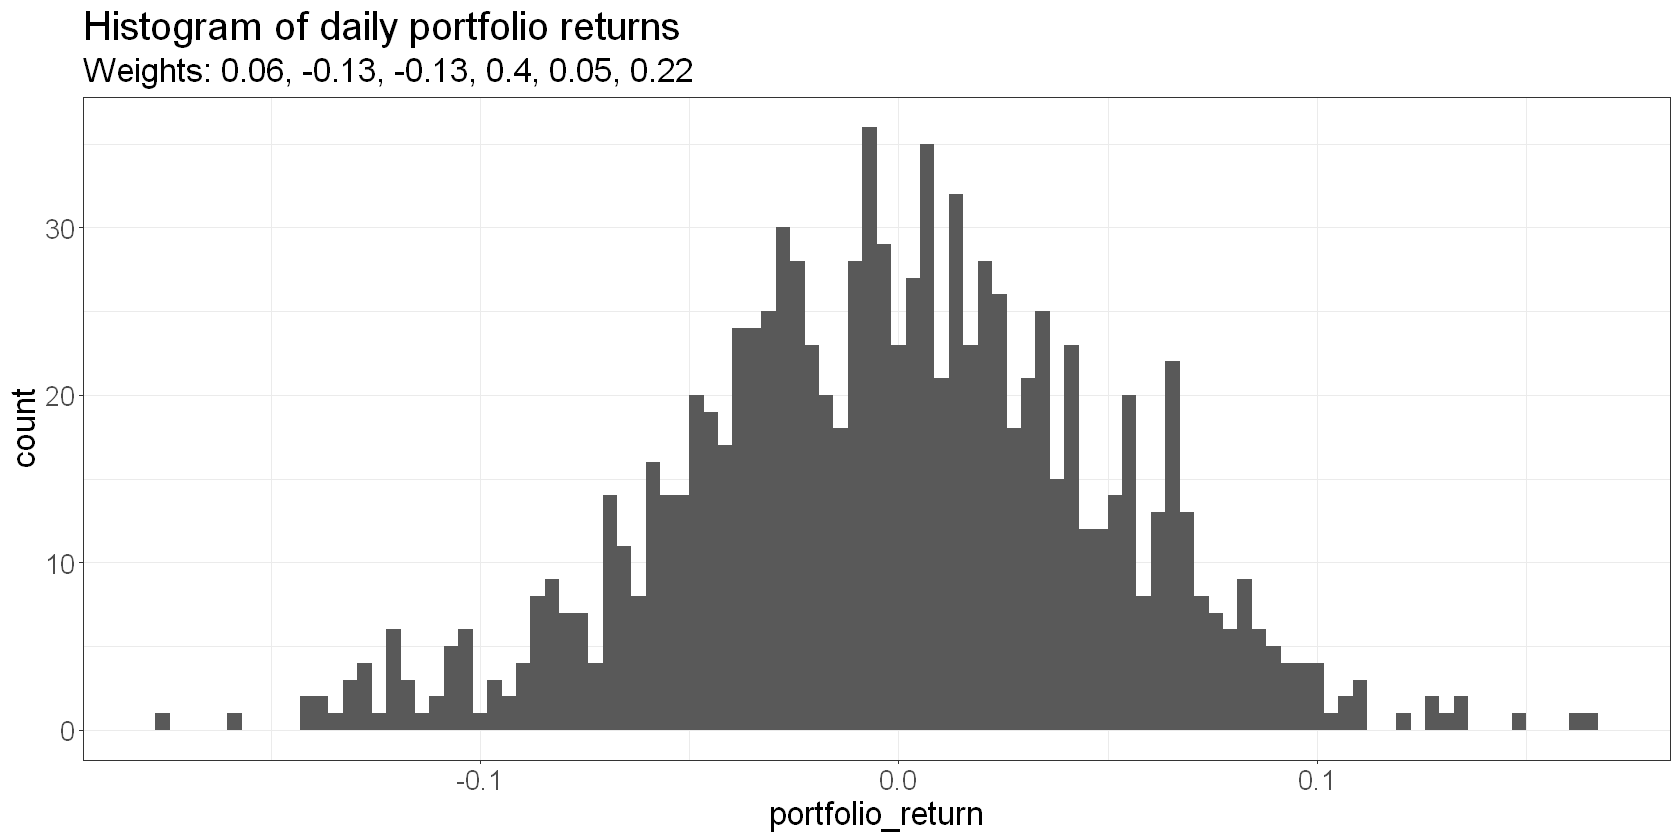

In [28]:
historical_port_returns <- historical_returns %*% w0

historical_port_returns %>% 
  data.frame(portfolio_return = ., index = c(1:nrow(historical_returns))) %>% 
  ggplot(aes(x = portfolio_return)) +
  geom_histogram(bins=100) +
  labs(
    title = "Histogram of daily portfolio returns",
    subtitle = glue::glue("Weights: {glue::glue_collapse(round(w0, 2), sep = ', ')}")
  )

You can see that we had several days in our 1,000-day sample in which we lost more than 10%. 

Next, let's figure out the 5th percentile of our daily returns. That is, what's the cutoff for our worst 5% of days?

In [29]:
# get the bottom 
quantile(historical_port_returns, 0.05)

5% 
-0.0862744

We can use that to firstly extract the bottom 5% of days:

In [30]:
worst_days <- historical_port_returns[historical_port_returns <= quantile(historical_port_returns, 0.05)]
head(worst_days)

[1] -0.14024361 -0.08755567 -0.08984701 -0.10054000 -0.12607714 -0.09627826

And now we can calculate the mean of our worst days:

In [31]:
mean(worst_days)

[1] -0.1145502

Now let's say we decide to exclude any weights that resulted in a mean worst day loss of 10% or more in the historical data.  

That would mean that the weights we chose here would get passed over by the optimiser, because the mean of their worst days was slightly worse than -10%. 

And that's the whole idea of this approach in a nutshell:
- Pick a maximum historical average worst day cutoff (say -10%)
- Define your set of "worst days" - here we simply grabbed the bottom 5% of daily returns
- Define a constraint such that the optimiser excludes weights whose average worst day in the past exceeded your cutoff value

A logical question would be *"Why complicate things by using the average of your worst days? Why not simply pick a single maximum daily loss and use that instead?"*

That would introduce a lot of sensitivity and randomness. For example, an otherwise optimal set of weights might have resulted in a single outlying bad return that would exclude it from the solution space. You might not want to exclude a set of weights due to a single bad day - you're essentially letting randomness drive the results to a very large extent.  

Constraining our cutoff to a mean of the bottom $x$% of bad days somewhat reduces this randomness.  

Now let's implement this approach using CVXR:

In [32]:
constrain_downside <- function(expected_returns, current_weights, historical_returns, max_loss = -0.1, costs, tau=1) {
  # define our weights vector as a CVXR::Variable
  weights <- Variable(length(expected_returns))
  # define an alpha term as the weighted sum of expected returns
    # again, express using linear algebra
  alpha_term <- (t(weights) %*% expected_returns)
  # define a costs term. depends on:
    # cost of trading - needs to be expressed such that it scales with expected returns
      # calculate as elementwise cost * absolute value of weights - current_weights
      # use CVXR::multiply and CVXR::abs
    # absolute distance of current_weights to our weights variable
      # the more our target weights differ from current weights, the more it costs to trade
      # this is a decent representation of fixed percentage costs, but doesn't capture minimum commissions
    # sum_entries is a CVXR function for summing the elements of a vector
  costs_term <- sum_entries(multiply(costs, abs(weights - current_weights))) # elementwise abs, multiply
  # define our objective
    # maximise our alpha less our costs term multiplied by tau
  objective <- Maximize(alpha_term)  #  - tau*costs_term
  # define a risk constraint as the average of our bottom 5% of bad days
    # you might want to pick of different value for k, or pass it as a parameter to the function
    k = round(nrow(historical_returns) * 0.05, 0)
    historical_port_returns = historical_returns %*% weights
    # sum_smallest sums the smallest k values
    ave_bad_day = CVXR::sum_smallest(historical_port_returns, k)/k
  # apply our no leverage and long only constraints
  constraints <- list(cvxr_norm(weights, 1) <= 1, weights >= 0, ave_bad_day >= max_loss)
  # specify the problem
  problem <- Problem(objective, constraints)
  # solve
  result <- solve(problem, solver = "ECOS")

  # return the values of the variable we solved for
  result$getValue(weights)
}

We'll set our maximum average worst day to -10% and apply a tau of 20 to our costs parameter:

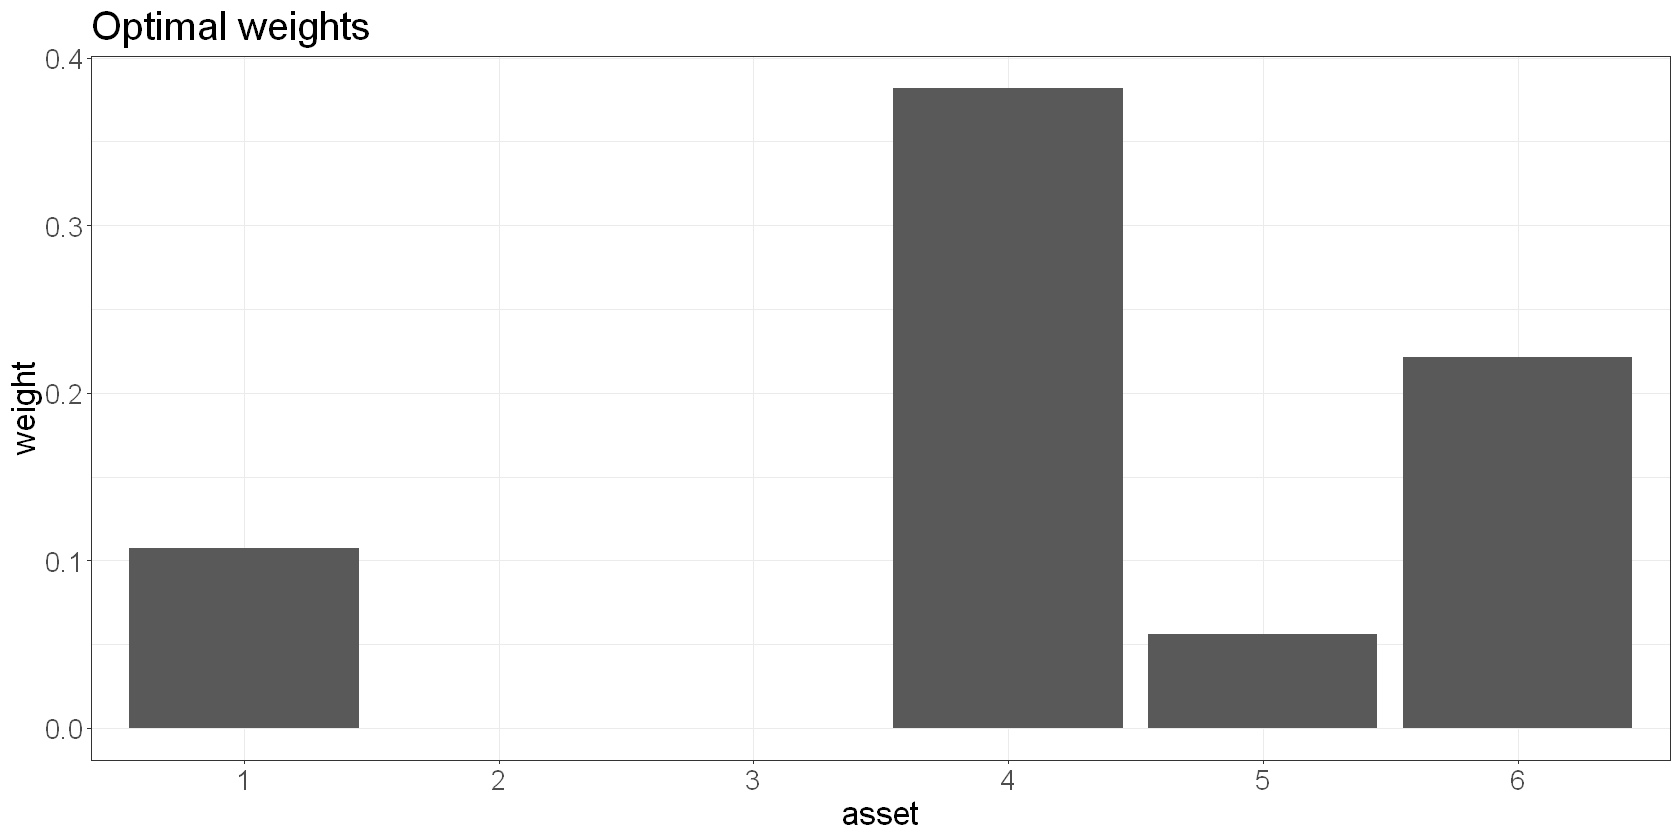

In [33]:
w <- constrain_downside(expected_returns = expected_returns, current_weights = w0, historical_returns = historical_returns, max_loss = -0.1, costs = 5./10000, tau=20)

# plot optimal weights
w %>%
  as.data.frame() %>%
  ggplot(aes(x = factor(1:num_assets), y = V1)) +
    geom_col() +
    labs(
      x = "asset",
      y = "weight",
      title = "Optimal weights"
    )

Let's have a look at the historical returns given these weights:

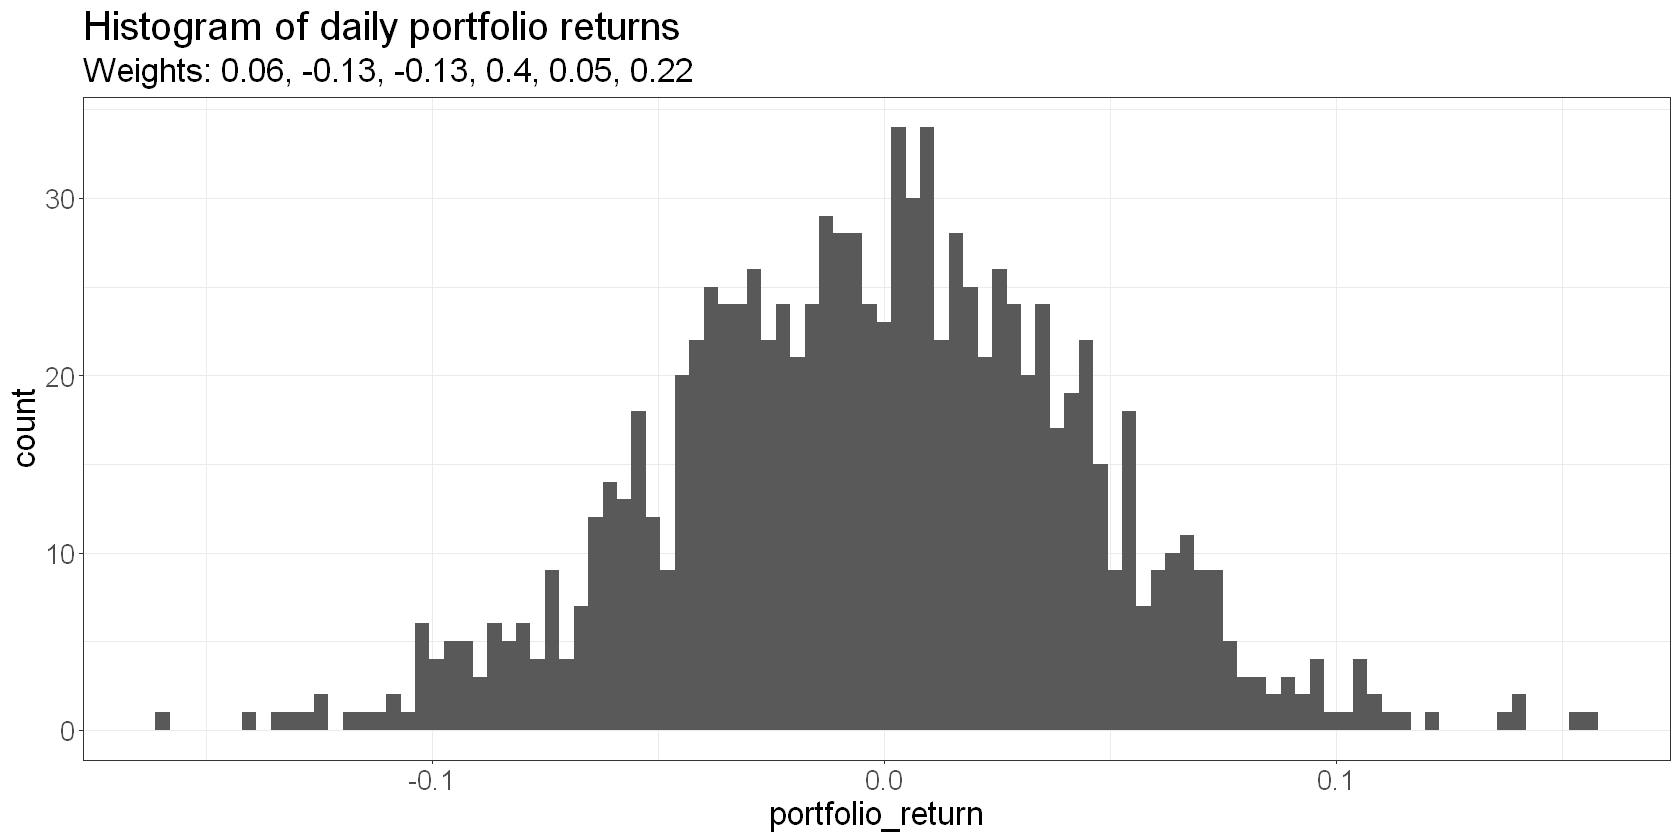

In [34]:
# historical daily portfolio returns at these weights
historical_port_returns <- historical_returns %*% w

historical_port_returns %>% 
  data.frame(portfolio_return = ., index = c(1:nrow(historical_returns))) %>% 
  ggplot(aes(x = portfolio_return)) +
  geom_histogram(bins=100) +
  labs(
    title = "Histogram of daily portfolio returns",
    subtitle = glue::glue("Weights: {glue::glue_collapse(round(w0, 2), sep = ', ')}")
  )

In [35]:
# what's the mean of our bottom 5% of bad days?
worst_days <- historical_port_returns[historical_port_returns <= quantile(historical_port_returns, 0.05)]
mean(worst_days)

[1] -0.1

You can see that the average of the worst days given these weights did indeed come in just north of our cutoff of -10%.

## Conclusion

The purpose of this article was to build your intuition for convex optimisation. Specifcally, how will certain constraints and objectives influence the optimiser's decisions?

We also saw several examples of constructing different optimisation problems using the CVXR library, which provides a high-level convex optimisation modelling language with user-friendly syntax.

In particular, we saw that we can construct the trading problem as a mean-variance optimisation that includes costs. Under this framework, we can essentially control the strategy's behaviour using two parameters: our risk version (lambda) and our propensity to trade (tau). In the next article, we'll see how we can use simulation to pick appropriate values for these parameters. 

Given the difficulties around covariance estimates and the sensitivity to small changes in these values, we also saw an approach that defines risk in terms of historical losses rather than covariances and portfolio volatility. The main drawback with this approach is that the future will likely not look exactly like the past. But maybe it will look enough like the past that this approach is feasible. 

Finally, we underline the point that convex optimisation is not a source of alpha itself. It's simply a tool to help you navigate the various operational trade-offs involved with harnessing your edges, and is entirely dependent on the quality of your forecasts.  